<a href="https://colab.research.google.com/github/sumitthakur24/ML/blob/master/t_SNE_(Amazon_fine_food_review).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# AMAZON FINE FOOD(using t-SNE)

### Objective:
To determine the review polarity using color coding

In [0]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import sqlite3
import numpy as np
import matplotlib.pyplot as plt
import nltk
import string
import pandas as pd
import seaborn as sns

from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve,auc
from nltk.stem.porter import PorterStemmer

In [0]:
#using sqlite to read data
conn=sqlite3.connect("F:\\software\\py\\amazon food review\\database.sqlite")

In [0]:
filter_data=pd.read_sql_query("""SELECT * FROM Reviews WHERE Score !=3""",conn)
print(filter_data.shape)
filter_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [0]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x<3:
        return 'negative'
    else:
        return 'positive'

#changing score to <3 to neagtive and >3 to positive
actual_score=filter_data['Score']
pos_neg=actual_score.map(partition)
filter_data['Score']=pos_neg
print(filter_data.shape)
filter_data.head()

(525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## Data Cleaning

In [0]:
#sorting data a/c to ProductId in ascending order 
sorted_data=filter_data.sort_values('ProductId',axis=0,ascending=True,kind='quicksort')

#drop duplicates
final_data=sorted_data.drop_duplicates(subset={'UserId','ProfileName','Time','Text'},keep='first')
final_data.shape

(364173, 10)

In [0]:
#percentage data left
(final_data.size)/(filter_data.size)*100#percentage data left
(final_data.size)/(filter_data.size)*100

69.25890143662969

In [0]:
final_data=final_data[final_data.HelpfulnessNumerator<=final_data.HelpfulnessDenominator]
final_data.shape

(364171, 10)

In [0]:
final_data['Score'].value_counts()

positive    307061
negative     57110
Name: Score, dtype: int64

## Text Processing

In [0]:
import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer


In [0]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
stop=set(stopwords.words('english'))
sno=nltk.stem.SnowballStemmer('english')
#cleaning HTML tags
def cleanHtml(sentence):
    cleanr=re.compile('<.*?>')
    cleantext=re.sub(cleanr,' ',sentence)
    return cleantext

#cleaning punctuation
def cleanpunc(sentence):
    clean=re.sub(r'[?|!|\'|"|#]',r'',sentence)
    cleaned = re.sub(r'[.|,|)|(|\|/]',r' ',cleaned)
    return  cleaned

## Bag OF Words(BoW)

In [0]:
count_vector=CountVectorizer()
final_count=count_vector.fit_transform(final_data['Text'][0:2000].values)
bow_final=pd.DataFrame(final_count.toarray())
bow_final.shape

(2000, 10800)

In [0]:
#data standardizing
from sklearn.preprocessing import StandardScaler
stand_data=StandardScaler()
labels=final_data['Score'].iloc[0:2000]
#labels.shape

In [0]:
stand_data=stand_data.fit_transform(bow_final)

In [0]:
from sklearn.manifold import TSNE
model= TSNE(n_components=2, random_state=0 ,perplexity=30)
tsne_data=model.fit_transform(bow_final)

#plotting
tsne_d=np.vstack((tsne_data.T,labels.T)).T
tsne_d.shape

(2000, 3)

In [0]:
tsne_df=pd.DataFrame(tsne_d, columns=('f 1','f 2','Score'))

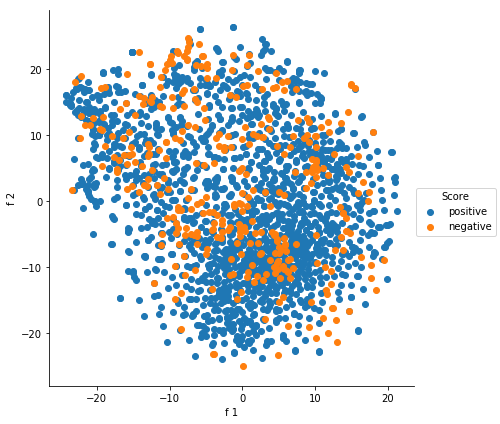

In [0]:
sns.FacetGrid(tsne_df,hue="Score", size=6).map(plt.scatter,'f 1','f 2').add_legend()
plt.show()

## TF-IDF

In [0]:
tfidf_vect=TfidfVectorizer(ngram_range=(1,2))
tfidf_count=tfidf_vect.fit_transform(final_data['Text'][0:2000].values)
type(tfidf_count)

scipy.sparse.csr.csr_matrix

In [0]:
tfidf_count.shape

(2000, 98992)

In [0]:
tfidf_final=pd.DataFrame(tfidf_count.toarray())

In [0]:
model1=TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data1=model1.fit_transform(tfidf_final)
tsne_data1.shape

(2000, 2)

In [0]:
tsne_d1=np.vstack((tsne_data1.T,labels.T)).T
tsne_d1.shape

(2000, 3)

In [0]:
tsne_df1=pd.DataFrame(tsne_d1, columns=('f 1','f 2','Score'))

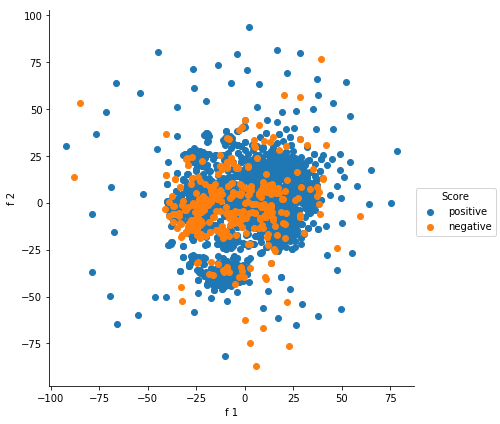

In [0]:
sns.FacetGrid(tsne_df1, hue='Score', size=6).map(plt.scatter, 'f 1','f 2').add_legend()
plt.show()

# Word2Vec

In [0]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

C:\Users\sumit\Anaconda3\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


In [0]:
#Code for implementing step-by-step the checks mentioned in the pre-processing phase
#training own w2v
i=0
final_string=[]
for sent in final_data['Text'].values:
    filtered_sent=[]
    sent=cleanHtml(sent)
    #print(sent)
    for w in sent.split():
        #print(w)
        #for cleaned_word in cleanpunc(w).split():
        if(w.isalpha()):
            filtered_sent.append(w.lower())
        else:
            continue
    final_string.append(filtered_sent)

In [0]:
print(len(final_string))

364171


In [0]:
w2v_model=Word2Vec(final_string, min_count=5, workers=4, size=50)
#w2v_words=w2v_model.wv.vocab
#print(len(w2v_words))

In [0]:
w2v_model.wv.most_similar('tasty')

[('satisfying', 0.829119086265564),
 ('delicious', 0.8263711929321289),
 ('tastey', 0.8218954801559448),
 ('yummy', 0.8032213449478149),
 ('filling', 0.760448694229126),
 ('flavorful', 0.7600867748260498),
 ('nutritious', 0.7428008913993835),
 ('hearty', 0.7304298877716064),
 ('versatile', 0.7247272729873657),
 ('addictive', 0.7183544039726257)]

## Avg W2V

In [0]:
sent_vectors=[]
for sent in final_string:
    sent_vect=np.zeros(50)
    cnt_words=0
    for word in sent:
        #if word in w2v_words:
        try:
            vec=word2vec.model.wv[word]
            sent_vect+=vec
            cnt_words+=1
        except:
            pass
   # if cnt_words!=0:
    sent_vect /=cnt_words
    sent_vectors.append(sent_vect)
print(len(sent_vectors))
print(len(sent_vectors[0]))

364171
50


In [0]:
w2v_final=pd.DataFrame(sent_vectors[0:2000])
w2v_final.shape

(2000, 50)

In [0]:
w2v_fin=np.nan_to_num(w2v_final)

In [0]:
std_data=StandardScaler()
std_data=std_data.fit_transform(w2v_fin)

In [0]:
model2=TSNE(n_components=2, random_state=0, perplexity=30)
tsne_data2=model2.fit_transform(w2v_fin)
tsne_data2.shape

(2000, 2)

In [0]:
tsne_d2=np.vstack((tsne_data2.T,labels.T)).T
tsne_d2.shape

(2000, 3)

In [0]:
tsne_df2=pd.DataFrame(tsne_d2, columns=('Dim1','Dim2','Score'))

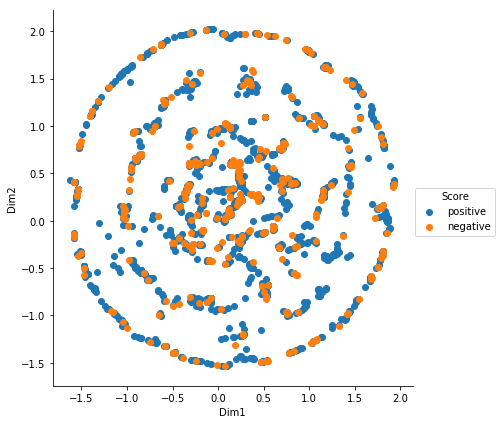

In [0]:
sns.FacetGrid(tsne_df2, hue='Score', size=6).map(plt.scatter,'Dim1','Dim2').add_legend()
plt.show()

## TF-IDF W2V

In [0]:
tfidf_feat=tfidf_vect.get_feature_names()
tfidf_sent_vect=[]
row=0
for sent in final_string:
   # print(sent)
    sent_vect=np.zeros(50)
    weight_sum=0
    for word in sent:
        #print(word)
        #if word in w2v_words:
        try:
            vec=word2vec.model.wv[word]
            tf_idf = tfidf_final[row, tfidf_feat.index(word)]
            sent_vect += (vec * tf_idf)
            weight_sum += tf_idf 
        except:
            pass
    #if weight_sum != 0:
    sent_vect /= weight_sum
    tfidf_sent_vect.append(sent_vect)
    row += 1
print(len(tfidf_sent_vect))

364171


In [0]:
tfw2v_final=pd.DataFrame(tfidf_sent_vect[0:2000])
tfw2v_final.shape

(2000, 50)

In [0]:
tfw2v_fin=np.nan_to_num(tfw2v_fin)

In [0]:
std_data2=StandardScaler()
std_data2=std_data2.fit_transform(tfw2v_fin)

In [0]:
model3=TSNE(n_components=2, random_state=0, perplexity=30)


In [0]:
tsne_data3=model3.fit_transform(std_data2)
tsne_data3.shape

(2000, 2)

In [0]:
tsne_d3=np.vstack((tsne_data3.T,labels)).T
tsne_d3.shape

(2000, 3)

In [0]:
tsne_df3=pd.DataFrame(tsne_d2, columns=('f 1','f 2','Score'))

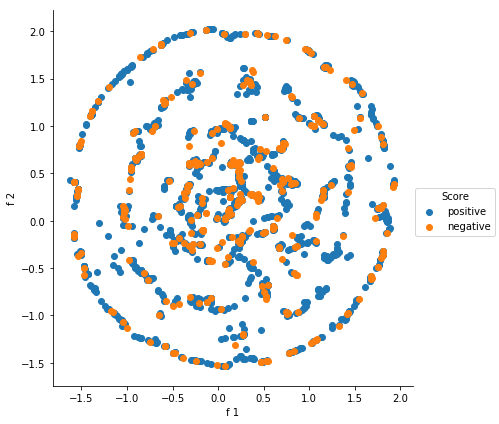

In [0]:
sns.FacetGrid(tsne_df3, hue='Score', size=6).map(plt.scatter,'f 1','f 2').add_legend()
plt.show()